## Dataset Source
https://www.kaggle.com/phylake1337/fire-dataset/notebooks

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import random
import seaborn as sns
from tqdm import tqdm
from PIL import Image 
import cv2
sns.set_theme()

In [49]:
DATADIR = './fire_dataset'
IMG_SIZE = (299,299)
NUM_CLASSES = len(os.listdir(DATADIR))

#Split data into train, test, and validation
def split_data(training_data):
    train_data = []
    validation_data = []
    test_data = []
    for i in range(NUM_CLASSES):
        i_data = []
        for features,label in training_data:
            if label == i:
                i_data.append([features,label])
        random.shuffle(i_data)
        num_samples = len(i_data)
        test_split = round(num_samples*0.6)
        validation_split = round(num_samples*.15)
        train_data+= i_data[0:test_split]
        validation_data += i_data[test_split:test_split+validation_split]
        test_data+=i_data[test_split+validation_split:len(i_data)]
        print(len(i_data))
    return train_data,test_data, validation_data

#Create training data for grayscale image
def create_training_data():
    training_data = []
    for i,category in enumerate(os.listdir(DATADIR)):
        label = i
        print("adding", category)
        for i, path in enumerate(os.listdir(os.path.join(DATADIR,category))):
            if i > 489: #To keep dataset balanced, same number of fire & non-fire images
                break
            img = Image.open(os.path.join(DATADIR,category,path)).convert('L')
            img = img.resize(IMG_SIZE)
            img_array = np.asarray(img)
            training_data.append([img_array,label])
    return training_data

#Create training data using R/G color ratio
def create_training_data_CR():
    training_data = []
    for i,category in enumerate(os.listdir(DATADIR)):
        label = i
        print("adding", category)
        for i, path in enumerate(os.listdir(os.path.join(DATADIR,category))):
            if i > 489: #To keep dataset balanced, same number of fire & non-fire images
                break
            img = Image.open(os.path.join(DATADIR,category,path))
            img = img.resize(IMG_SIZE)
            I = np.asarray(img)
            if I.shape == (299,299,3): #keeping only color images
                I_intensity = (I[:,:,1] > 100) # identify pixels with low GREEN values - they are less reliable
                I_cr = I[:,:,0]/I[:,:,1] # This is the ratio of Red (0) to Green (1)
                I_cr[~I_intensity] = 1.0 # small green values would have infinite or near infinite ratios, replace with a "big" number instead
                I_sig = (I[:,:,0] > 1.2*I[:,:,1]) & I_intensity
                training_data.append([I_sig,label])
    return training_data

#Create RGB training data
def create_training_data_RGB():
    training_data = []
    for i,category in enumerate(os.listdir(DATADIR)):
        label = i
        print("adding", category)
        for i, path in enumerate(os.listdir(os.path.join(DATADIR,category))):
            if i < 489:
                img = Image.open(os.path.join(DATADIR,category,path))
                img = img.resize(IMG_SIZE)
                img_array = np.asarray(img)
                if img_array.shape == (299,299,3):  #keeping only color images
                    training_data.append([img_array,label])
    return training_data

#Reshape and normalize features
def reshape_data(data, shape):
    X = []
    Y = []
    for features, label in data:
        X.append(features.reshape(shape))
        Y.append(tf.keras.utils.to_categorical(label, num_classes=2, dtype="float32"))
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_features = scaler.fit_transform(X)
    Y = np.asarray(Y)
    return rescaled_features,Y

#Reshape and normalize features for 2-D data
def reshape_data_2D(data, shape):
    X = []
    Y = []
    for features, label in data:
        X.append(features.reshape(shape))
        Y.append(tf.keras.utils.to_categorical(label, num_classes=2, dtype="float32"))
    X = np.asarray(X)/255.0
    Y = np.asarray(Y)
    return X,Y

(299, 299, 3)


C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


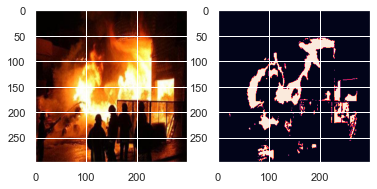

In [11]:
#Plot an image next to it's color ratio binary image
fig, ax = plt.subplots(ncols = 2)
category = os.listdir(DATADIR)[0]
path = os.listdir(os.path.join(DATADIR,category))[20]
img = Image.open(os.path.join(DATADIR,category,path))

img = img.resize(IMG_SIZE)
I = np.asarray(img)
print(I.shape)
I_intensity = (I[:,:,1] > 100)
I_cr = I[:,:,0]/I[:,:,1] 
I_cr[~I_intensity] = 1.0
I_sig = (I[:,:,0] > 1.3*I[:,:,1]) & I_intensity
ax[0].imshow(img)
ax[1].imshow(I_sig)

In [29]:
model = Sequential() # declare model
model.add(Dense(NUM_CLASSES, input_shape=(299*299, ), kernel_initializer='he_normal')) # firstlayer
model.add(Activation('tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(NUM_CLASSES, kernel_initializer='he_normal')) # last layer
model.add(Activation('softmax'))
opt = SGD(lr=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 5,restore_best_weights=True)]

In [14]:
#Create training data for grayscale simple model
INPUT_SHAPE = (299*299,)
training_data = create_training_data()

train_data, test_data, validation_data = split_data(training_data)
x_train, y_train = reshape_data(train_data, INPUT_SHAPE)
x_test, y_test = reshape_data(test_data, INPUT_SHAPE)
x_val, y_val = reshape_data(validation_data, INPUT_SHAPE)
print("Train:", x_train.shape, "Test:", x_test.shape, "Validation:", x_val.shape)

adding fire_images
adding non_fire_images
755
488
Train: (746, 89401) Test: (311, 89401) Validation: (186, 89401)


In [18]:
#Train model on grayscale images
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs = 100,batch_size = 32,callbacks = callbacks)

# Report Results
# print(history.history)
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
24/24 [==============================] - 0s 13ms/step - loss: 0.6895 - accuracy: 0.5389 - val_loss: 0.6729 - val_accuracy: 0.6075
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6741 - accuracy: 0.6059 - val_loss: 0.6697 - val_accuracy: 0.6075
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6708 - accuracy: 0.6059 - val_loss: 0.6676 - val_accuracy: 0.6129
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6671 - accuracy: 0.6247 - val_loss: 0.6645 - val_accuracy: 0.6129
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6636 - accuracy: 0.6273 - val_loss: 0.6613 - val_accuracy: 0.6129
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6591 - accuracy: 0.6233 - val_loss: 0.6587 - val_accuracy: 0.6183
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 0.6549 - accuracy: 0.6260 - val_loss: 0.6639 - val_accuracy: 0.6183
Epoch 8/100


In [25]:
#Create training data for color ratio simple model
INPUT_SHAPE = (299*299,)
training_data = create_training_data_CR()

train_data, test_data, validation_data = split_data(training_data)
x_train, y_train = reshape_data(train_data, INPUT_SHAPE)
x_test, y_test = reshape_data(test_data, INPUT_SHAPE)
x_val, y_val = reshape_data(validation_data, INPUT_SHAPE)
print("Train:", x_train.shape, "Test:", x_test.shape, "Validation:", x_val.shape)

adding fire_images


C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


adding non_fire_images
487
478
Train: (579, 89401) Test: (241, 89401) Validation: (145, 89401)


In [32]:
#Train model on color ratio binary images
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs = 100,batch_size = 32,callbacks = callbacks)

# Report Results
# print(history.history)
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2592 - accuracy: 0.9793 - val_loss: 0.3921 - val_accuracy: 0.9172
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2544 - accuracy: 0.9793 - val_loss: 0.3881 - val_accuracy: 0.9103
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2501 - accuracy: 0.9793 - val_loss: 0.3850 - val_accuracy: 0.9103
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2460 - accuracy: 0.9793 - val_loss: 0.3817 - val_accuracy: 0.9172
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2420 - accuracy: 0.9793 - val_loss: 0.3783 - val_accuracy: 0.9172
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2380 - accuracy: 0.9793 - val_loss: 0.3747 - val_accuracy: 0.9172
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2343 - accuracy: 0.9793 - val_loss: 0.3719 - val_accuracy: 0.9172
Epoch 8/100
1

Epoch 59/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1194 - accuracy: 0.9879 - val_loss: 0.2808 - val_accuracy: 0.9241
Epoch 60/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1183 - accuracy: 0.9879 - val_loss: 0.2800 - val_accuracy: 0.9241
Epoch 61/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1173 - accuracy: 0.9879 - val_loss: 0.2791 - val_accuracy: 0.9241
Epoch 62/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1163 - accuracy: 0.9879 - val_loss: 0.2786 - val_accuracy: 0.9241
Epoch 63/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.9879 - val_loss: 0.2778 - val_accuracy: 0.9241
Epoch 64/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9879 - val_loss: 0.2773 - val_accuracy: 0.9241
Epoch 65/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1133 - accuracy: 0.9879 - val_loss: 0.2767 - val_accuracy: 0.9241
Epoch 

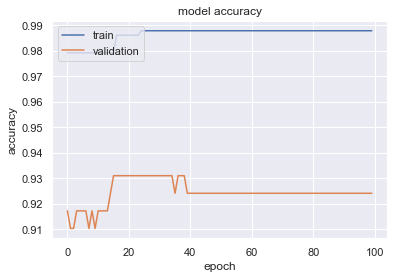

In [33]:
#Plot Epoch vs. Model Accuracy 
plt.clf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

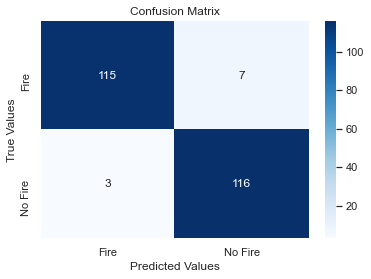

In [28]:
#Create labels for confusion matrix
labels = ["Fire", "No Fire"]
    
#Get data for confusion matrix
pred = np.argmax(y_pred, axis=-1)
test = np.argmax(y_test, axis=-1)
# print(y_pred)
# print(y_test)
confusion_data = confusion_matrix(test, pred)

#plot incorrectly classified images
heat_map = sns.heatmap(confusion_data, cmap='Blues',annot=True, linewidths=0, fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.title("Confusion Matrix")
plt.show()

In [37]:
#Create 2D grayscale training data
INPUT_SHAPE = (299,299, 1)
training_data = create_training_data()

train_data, test_data, validation_data = split_data(training_data)
x_train, y_train = reshape_data_2D(train_data, INPUT_SHAPE)
x_test, y_test = reshape_data_2D(test_data, INPUT_SHAPE)
x_val, y_val = reshape_data_2D(validation_data, INPUT_SHAPE)
print("Train:", x_train.shape, "Test:", x_test.shape, "Validation:", x_val.shape)

adding fire_images
adding non_fire_images
490
488
Train: (587, 299, 299, 1) Test: (244, 299, 299, 1) Validation: (147, 299, 299, 1)


In [38]:
#Building a more complex model
model = Sequential()
model.add(Conv2D(128,(2,2),input_shape = INPUT_SHAPE,activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

opt = SGD(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 5,restore_best_weights=True)]

In [39]:
#Train complex model on grayscale images
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs = 20,batch_size = 64,callbacks = callbacks)

# Report Results
# print(history.history)
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
19/19 [==============================] - 120s 6s/step - loss: 0.6854 - accuracy: 0.5332 - val_loss: 0.6847 - val_accuracy: 0.5034
Epoch 2/100
19/19 [==============================] - 118s 6s/step - loss: 0.6778 - accuracy: 0.5128 - val_loss: 0.6803 - val_accuracy: 0.5238
Epoch 3/100
19/19 [==============================] - 121s 6s/step - loss: 0.6723 - accuracy: 0.5622 - val_loss: 0.6775 - val_accuracy: 0.5034
Epoch 4/100
19/19 [==============================] - 122s 6s/step - loss: 0.6672 - accuracy: 0.5417 - val_loss: 0.6722 - val_accuracy: 0.5646
Epoch 5/100
16/19 [========================>.....] - ETA: 17s - loss: 0.6616 - accuracy: 0.5898

KeyboardInterrupt: 

In [42]:
#Create 2D color ratio training data
INPUT_SHAPE = (299,299, 1)
training_data = create_training_data_CR()

train_data, test_data, validation_data = split_data(training_data)
x_train, y_train = reshape_data_2D(train_data, INPUT_SHAPE)
x_test, y_test = reshape_data_2D(test_data, INPUT_SHAPE)
x_val, y_val = reshape_data_2D(validation_data, INPUT_SHAPE)
print("Train:", x_train.shape, "Test:", x_test.shape, "Validation:", x_val.shape)

adding fire_images


C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\kaitl\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


adding non_fire_images
487
478
Train: (579, 299, 299, 1) Test: (241, 299, 299, 1) Validation: (145, 299, 299, 1)


In [43]:
#Train complex model on color ratio images
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs = 40,batch_size = 32,callbacks = callbacks)

# Report Results
# print(history.history)
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/20
10/10 [==============================] - 109s 11s/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6680 - val_accuracy: 0.5918
Epoch 2/20
 8/10 [=======================>......] - ETA: 22s - loss: 0.6932 - accuracy: 0.4961

KeyboardInterrupt: 

In [50]:
#Create 2D RGB image training data
INPUT_SHAPE = (299,299, 3)
training_data = create_training_data_RGB()

train_data, test_data, validation_data = split_data(training_data)
x_train, y_train = reshape_data_2D(train_data, INPUT_SHAPE)
x_test, y_test = reshape_data_2D(test_data, INPUT_SHAPE)
x_val, y_val = reshape_data_2D(validation_data, INPUT_SHAPE)
print("Train:", x_train.shape, "Test:", x_test.shape, "Validation:", x_val.shape)

adding fire_images
adding non_fire_images
486
478
Train: (579, 299, 299, 3) Test: (240, 299, 299, 3) Validation: (145, 299, 299, 3)


In [51]:
#Building a more complex model
model = Sequential()
model.add(Conv2D(128,(2,2),input_shape = INPUT_SHAPE,activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

opt = SGD(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 5,restore_best_weights=True)]

In [ ]:
#Train complex model on color images
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs = 40,batch_size = 32,callbacks = callbacks)

# Report Results
# print(history.history)
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')